### Fama and French Factor Model: Understanding the Factors ### 

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from data_downloader import get_market_data
from portfolios_toolkit import calculate_analytics

### Size Factor ###

In [3]:
def build_returns_dataframe(
        tickers: list, 
        start_date='2015-01-01', 
        end_date='2025-01-01'
) -> pd.DataFrame:
    # DataFrame
    df_returns = pd.DataFrame()

    # Loop
    for ticker in tickers:
        df = get_market_data(ticker, start_date, end_date, returns=True)
        if not df.empty:
            df_returns[ticker] = df['returns']
            print(f'Data Ready for {ticker}')

    return df_returns

In [4]:
# Import tickers categorized by market capitalization
tickers_df = pd.read_csv('../additional_data/mktcap_companies.csv')
tickers_df.drop(columns='Unnamed: 0', inplace=True)

tickers_df

,mega_companies,large_companies,mid_companies,small_companies,micro_companies
0,MSFT,ISRG,ASND,BGM,TATT
1,NVDA,ACN,CUBE,FBK,JELD
2,AAPL,T,DSGX,AIN,NFGC
3,AMZN,SHEL,BEPC,AGM-A,CZFS
4,GOOGL,MRK,GGAL,WGS,PHAT
5,META,AMD,WBA,BUSE,TBN
6,TSLA,VZ,ESTC,NBTB,QUAD
7,AVGO,PEP,KMX,NAMS,MVIS
8,BRK-B,RTX,GL,HUN,LPAA
9,TSM,BKNG,JHX,KYMR,ABEO


In [5]:
# Set a dictionary
company_sizes = {
    'mega': tickers_df['mega_companies'],
    'large': tickers_df['large_companies'],
    'mid': tickers_df['mid_companies'],
    'small': tickers_df['small_companies'],
    'micro': tickers_df['micro_companies'],
}

In [5]:
# Get the data
#returns_by_size = {}

#for size, tickers in company_sizes.items():
#    returns_by_size[size] = build_returns_dataframe(tickers, size)

In [6]:
# Create the Portfolios
#portfolios_df = pd.DataFrame({
#    f'{size}_portfolio': df.mean(axis=1, skipna=True)
#    for size, df in returns_by_size.items()
#})

In [6]:
portfolios_df = pd.read_csv(r'..\additional_data\mktcap_portfolios.csv')
portfolios_df.drop(columns='Unnamed: 0', inplace=True)

portfolios_df

,mega_portfolio,large_portfolio,mid_portfolio,small_portfolio,micro_portfolio
0,-0.020738,-0.017735,-0.022765,-0.021818,-0.018617
1,-0.009491,-0.007760,0.002066,-0.017739,-0.017479
2,0.008611,0.013438,0.017103,0.010869,0.009259
3,0.018500,0.015096,0.015100,0.010680,0.017039
4,-0.009794,-0.008899,-0.008906,-0.004183,-0.010811
...,...,...,...,...,...
2510,0.014241,0.006923,0.011832,0.001482,0.008005
2511,-0.001361,-0.000548,-0.000662,0.011266,0.029688
2512,-0.013462,-0.003921,-0.010688,-0.020253,-0.009018
2513,-0.012331,-0.009068,-0.012984,-0.007885,0.001527


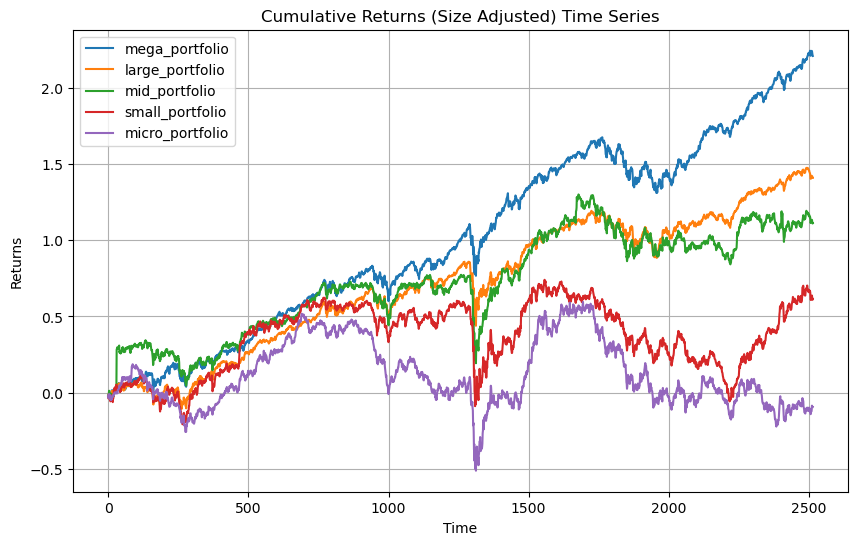

In [7]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(portfolios_df.cumsum(), label=portfolios_df.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [9]:
# Analytics Table
size_analytics_table = calculate_analytics(portfolios_df)

size_analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
mega_portfolio,0.221636,0.201111,1.102057,-0.003653,-0.019324
large_portfolio,0.141323,0.186145,0.759208,-0.004203,-0.017600
mid_portfolio,0.111509,0.247632,0.450300,-0.005800,-0.022252
small_portfolio,0.061745,0.256378,0.240838,-0.007966,-0.023730
micro_portfolio,-0.009479,0.264096,-0.035892,-0.010272,-0.024803


In [10]:
# Calculate a primitive SMB premium
SMB = (1/2*(portfolios_df['small_portfolio']+portfolios_df['micro_portfolio']) - 
       1/2*(portfolios_df['mega_portfolio']+portfolios_df['large_portfolio']))  

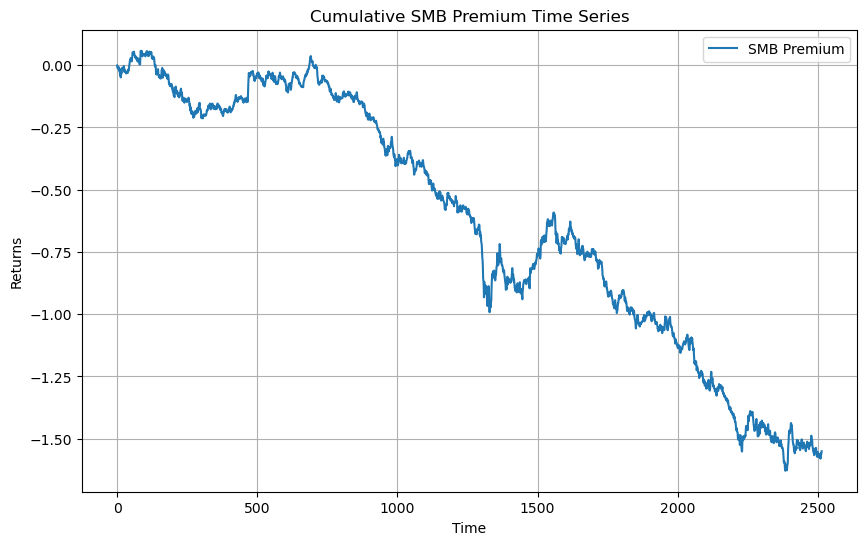

In [11]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(SMB.cumsum(), label='SMB Premium', alpha=1)

# Config
plt.title('Cumulative SMB Premium Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [12]:
# Annualized Returns
annualized_returns = portfolios_df.mean() * 252 * 100
annualized_returns.name = 'annualized_returns'

annualized_returns

mega_portfolio     22.163596
large_portfolio    14.132254
mid_portfolio      11.150866
small_portfolio     6.174542
micro_portfolio    -0.947885
Name: annualized_returns, dtype: float64

In [13]:
# Annualized Volatility
annualized_volatility = portfolios_df.std() * np.sqrt(252) * 10
annualized_volatility.name = 'annualized_volatility'

annualized_volatility

mega_portfolio     2.011111
large_portfolio    1.861447
mid_portfolio      2.476317
small_portfolio    2.563777
micro_portfolio    2.640959
Name: annualized_volatility, dtype: float64

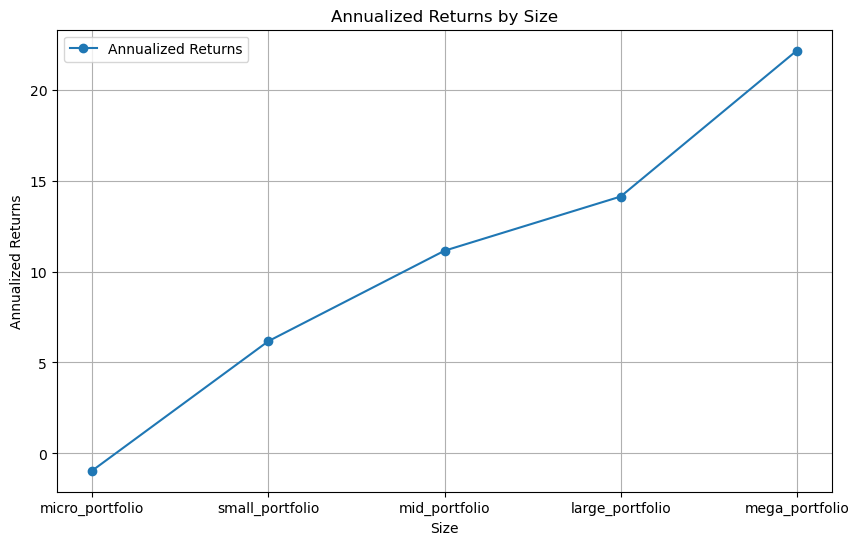

In [14]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(annualized_returns.iloc[::-1], label='Annualized Returns', alpha=1, marker='o')

# Config
plt.title('Annualized Returns by Size')
plt.xlabel('Size')
plt.ylabel('Annualized Returns')
plt.legend()
plt.grid()

# Show
plt.show()

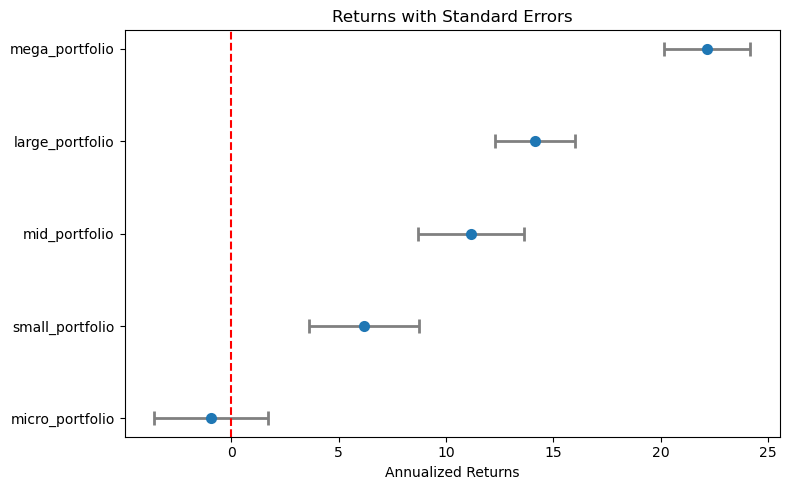

In [15]:
data = pd.DataFrame({
    'returns': annualized_returns.iloc[::-1],
    'volatility': annualized_volatility.iloc[::-1],
}, index=annualized_returns.iloc[::-1].index)

errors = data['volatility']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(
    x=data['returns'],                # x-values (betas)
    y=range(len(data)),               # y-positions
    xerr=errors,                      # confidence interval errors
    fmt='o',                          # circular markers for betas
    ecolor='gray',                    # color of the error bars
    capsize=5,                        # small caps on error bars
    elinewidth=2,                     # thickness of the error bars
    markeredgewidth=2                 # thickness of the circle edge
)

# Customize the plot
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data.index)
ax.axvline(0, color='red', linestyle='--')  # reference line
ax.set_xlabel('Annualized Returns')
ax.set_title('Returns with Standard Errors')

plt.tight_layout()
plt.show()

### Value Factor ###

In [16]:
# Define a High Value Stocks List
high_value_tickers = [
    "XOM",  # ExxonMobil
    "CVX",  # Chevron
    "JPM",  # JPMorgan
    "BAC",  # Bank of America
    "WFC",  # Wells Fargo
    "PFE",  # Pfizer
    "MRK",  # Merck
    "VZ",   # Verizon
    "T",    # AT&T
    "MMM",  # 3M
    "C",    # Citigroup
    "F",    # Ford
    "GM",   # General Motors
    "INTC", # Intel
    "IBM",  # IBM
    "MO",   # Altria
    "GILD", # Gilead
    "PRU",  # Prudential
    "MET",  # MetLife
    "DUK",  # Duke Energy
]

In [17]:
# And a Low Value Stocks List
low_value_tickers = [
    "TSLA",   # Tesla
    "NVDA",   # NVIDIA
    "AAPL",   # Apple
    "AMZN",   # Amazon
    "MSFT",   # Microsoft
    "META",   # Meta
    "NFLX",   # Netflix
    "SNOW",   # Snowflake
    "UBER",   # Uber
    "RIVN",   # Rivian
    "PLTR",   # Palantir
    "SHOP",   # Shopify
    "CRWD",   # CrowdStrike
    "ZS",     # Zscaler
    "PANW",   # Palo Alto
    "SQ",     # Block (Square)
    "COIN",   # Coinbase
    "SMCI",   # Supermicro
    "ABNB",   # Airbnb
    "ROKU",   # Roku
]

In [18]:
# Get the Data
high_value_returns = build_returns_dataframe(high_value_tickers)

[*********************100%***********************]  1 of 1 completed


Data Ready for XOM


[*********************100%***********************]  1 of 1 completed


Data Ready for CVX


[*********************100%***********************]  1 of 1 completed


Data Ready for JPM


[*********************100%***********************]  1 of 1 completed


Data Ready for BAC


[*********************100%***********************]  1 of 1 completed


Data Ready for WFC


[*********************100%***********************]  1 of 1 completed


Data Ready for PFE


[*********************100%***********************]  1 of 1 completed


Data Ready for MRK


[*********************100%***********************]  1 of 1 completed


Data Ready for VZ


[*********************100%***********************]  1 of 1 completed


Data Ready for T


[*********************100%***********************]  1 of 1 completed


Data Ready for MMM


[*********************100%***********************]  1 of 1 completed


Data Ready for C


[*********************100%***********************]  1 of 1 completed


Data Ready for F


[*********************100%***********************]  1 of 1 completed


Data Ready for GM


[*********************100%***********************]  1 of 1 completed


Data Ready for INTC


[*********************100%***********************]  1 of 1 completed


Data Ready for IBM


[*********************100%***********************]  1 of 1 completed


Data Ready for MO


[*********************100%***********************]  1 of 1 completed


Data Ready for GILD


[*********************100%***********************]  1 of 1 completed


Data Ready for PRU


[*********************100%***********************]  1 of 1 completed


Data Ready for MET


[*********************100%***********************]  1 of 1 completed

Data Ready for DUK


In [19]:
high_value_returns

,XOM,CVX,JPM,BAC,WFC,PFE,MRK,VZ,T,MMM,C,F,GM,INTC,IBM,MO,GILD,PRU,MET,DUK
Date,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.027743,-0.040793,-0.031537,-0.029481,-0.027805,-0.005441,0.014753,-0.008340,-0.009493,-0.022811,-0.032022,-0.039846,-0.014747,-0.011341,-0.015860,-0.005734,0.019614,-0.032254,-0.033959,-0.014500
2015-01-06,-0.005331,-0.000463,-0.026271,-0.030376,-0.021086,0.008310,0.038531,0.010042,0.001489,-0.010721,-0.035839,-0.009530,0.015034,-0.018813,-0.021802,0.005939,0.008846,-0.020963,-0.030789,0.016283
2015-01-07,0.010082,-0.000833,0.001524,0.004734,0.005934,0.013592,0.021161,-0.006474,0.005814,0.007223,0.009227,0.028323,0.028011,0.020758,-0.006557,0.018208,0.018567,0.000585,0.013172,0.003202
2015-01-08,0.016508,0.022625,0.022101,0.020451,0.021896,0.020203,0.019927,0.021207,0.009899,0.023685,0.014936,0.024952,0.009995,0.018430,0.021502,0.016701,0.027953,0.015898,0.015119,0.004017
2015-01-09,-0.001410,-0.020127,-0.017540,-0.018092,-0.016567,0.004605,-0.004625,-0.008942,-0.002989,-0.012360,-0.022587,-0.013712,-0.016995,0.001906,0.004346,-0.002369,-0.000880,-0.017889,-0.018641,0.001414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.000940,0.006067,0.016310,0.011102,0.014775,0.001123,0.000805,-0.003511,0.004805,0.010643,0.017476,0.012048,0.017913,0.009852,0.011113,-0.002055,0.005871,0.005887,0.006587,0.003770
2024-12-26,0.000845,0.000973,0.003420,0.003823,0.002372,-0.006754,0.004214,0.004012,0.000436,0.006271,0.004918,0.004978,0.012443,0.001959,0.002137,0.002856,0.004884,0.006769,0.006061,-0.006075
2024-12-27,-0.000094,0.000139,-0.008135,-0.004725,-0.009099,0.002256,-0.001704,-0.001002,-0.004365,-0.007652,-0.004918,-0.003980,0.001844,-0.006873,-0.009427,-0.004191,-0.003183,-0.008447,-0.006061,0.000277


In [20]:
# And the Portfolio
high_value_portfolio = high_value_returns.mean(axis=1)
high_value_portfolio.name = 'high_value_portfolio'

high_value_portfolio

Date
2015-01-05   -0.018467
2015-01-06   -0.006375
2015-01-07    0.009813
2015-01-08    0.018400
2015-01-09   -0.009173
                ...   
2024-12-24    0.007576
2024-12-26    0.003027
2024-12-27   -0.003967
2024-12-30   -0.010505
2024-12-31    0.004080
Name: high_value_portfolio, Length: 2515, dtype: float64

In [21]:
# Get the Data
low_value_returns = build_returns_dataframe(low_value_tickers)

[*********************100%***********************]  1 of 1 completed


Data Ready for TSLA


[*********************100%***********************]  1 of 1 completed


Data Ready for NVDA


[*********************100%***********************]  1 of 1 completed


Data Ready for AAPL


[*********************100%***********************]  1 of 1 completed


Data Ready for AMZN


[*********************100%***********************]  1 of 1 completed


Data Ready for MSFT


[*********************100%***********************]  1 of 1 completed


Data Ready for META


[*********************100%***********************]  1 of 1 completed


Data Ready for NFLX


[*********************100%***********************]  1 of 1 completed


Data Ready for SNOW


[*********************100%***********************]  1 of 1 completed


Data Ready for UBER


[*********************100%***********************]  1 of 1 completed


Data Ready for RIVN


[*********************100%***********************]  1 of 1 completed


Data Ready for PLTR


[*********************100%***********************]  1 of 1 completed


Data Ready for SHOP


[*********************100%***********************]  1 of 1 completed


Data Ready for CRWD


[*********************100%***********************]  1 of 1 completed


Data Ready for ZS


[*********************100%***********************]  1 of 1 completed


Data Ready for PANW


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Data Ready for COIN


[*********************100%***********************]  1 of 1 completed


Data Ready for SMCI


[*********************100%***********************]  1 of 1 completed


Data Ready for ABNB


[*********************100%***********************]  1 of 1 completed

Data Ready for ROKU


In [22]:
low_value_returns

,TSLA,NVDA,AAPL,AMZN,MSFT,META,NFLX,SNOW,UBER,RIVN,PLTR,SHOP,CRWD,ZS,PANW,COIN,SMCI,ABNB,ROKU
Date,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.042950,-0.017035,-0.028576,-0.020731,-0.009239,-0.016192,-0.052238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018846,NaN,-0.030997,NaN,NaN
2015-01-06,0.005648,-0.030787,0.000094,-0.023098,-0.014786,-0.013565,-0.017269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015311,NaN,-0.027399,NaN,NaN
2015-01-07,-0.001563,-0.002609,0.013925,0.010544,0.012625,0.000000,0.005178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029754,NaN,0.007299,NaN,NaN
2015-01-08,-0.001566,0.036927,0.037703,0.006813,0.028994,0.026309,0.021946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013295,NaN,0.051096,NaN,NaN
2015-01-09,-0.018981,0.004020,0.001072,-0.011818,-0.008441,-0.005644,-0.015578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010987,NaN,-0.005775,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.070991,0.003930,0.011413,0.017573,0.009330,0.013084,0.022425,0.009985,-0.002589,0.022295,0.020728,0.008477,0.011797,0.007074,0.006830,0.041885,0.057861,0.003488,0.009598
2024-12-26,-0.017787,-0.002070,0.003171,-0.008770,-0.002781,-0.007266,-0.008598,0.002572,-0.002434,-0.001424,-0.002918,-0.001999,-0.001943,0.001974,-0.005344,-0.018808,-0.017336,0.002442,-0.001006
2024-12-27,-0.050745,-0.021088,-0.013331,-0.014641,-0.017453,-0.005884,-0.018115,-0.029990,-0.007010,-0.028171,-0.037965,-0.016320,-0.028027,-0.016497,-0.012384,-0.032218,-0.053573,-0.014403,-0.031311


In [23]:
# And the Portfolio
low_value_portfolio = low_value_returns.mean(axis=1)
low_value_portfolio.name = 'low_value_portfolio'

low_value_portfolio

Date
2015-01-05   -0.022123
2015-01-06   -0.015164
2015-01-07    0.008350
2015-01-08    0.024613
2015-01-09   -0.008015
                ...   
2024-12-24    0.018220
2024-12-26   -0.004754
2024-12-27   -0.023638
2024-12-30   -0.016728
2024-12-31   -0.013123
Name: low_value_portfolio, Length: 2515, dtype: float64

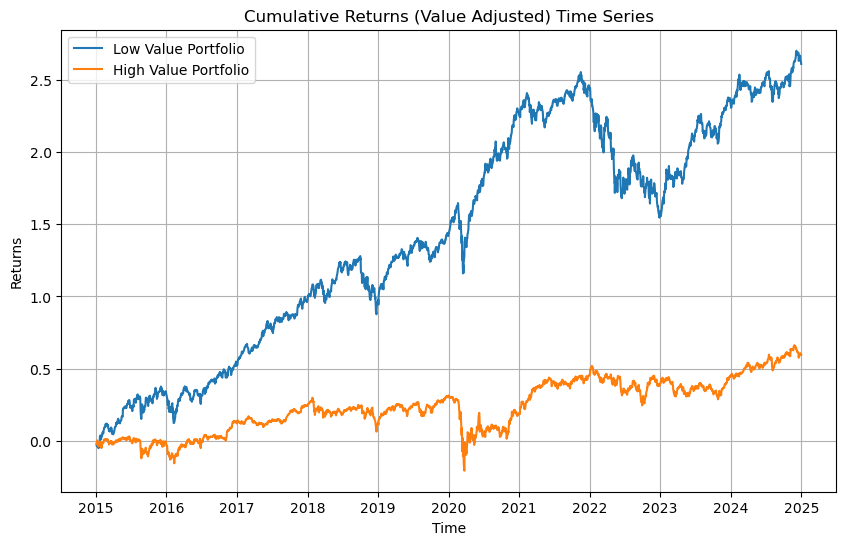

In [24]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(low_value_portfolio.cumsum(), label='Low Value Portfolio', alpha=1)
plt.plot(high_value_portfolio.cumsum(), label='High Value Portfolio', alpha=1)

# Config
plt.title('Cumulative Returns (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

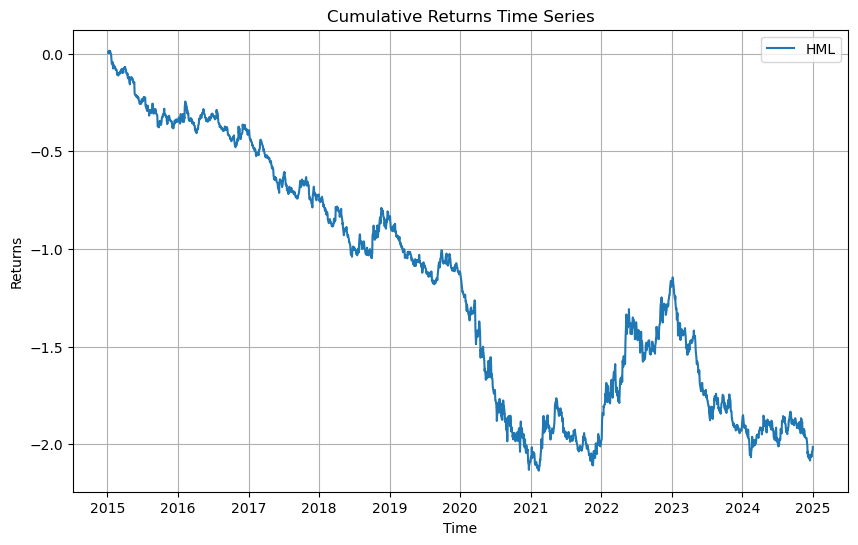

In [25]:
# Create Plot
HML = high_value_portfolio - low_value_portfolio

plt.figure(figsize=(10, 6))
plt.plot(HML.cumsum(), label='HML', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()